In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import SymLogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import rioxarray as rxr
from scipy.interpolate import RegularGridInterpolator
from shapely.geometry import Point
import geopandas as gpd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.interpolate import griddata
from osgeo import gdal
import rasterio
import os
from netCDF4 import Dataset
# import pygmt

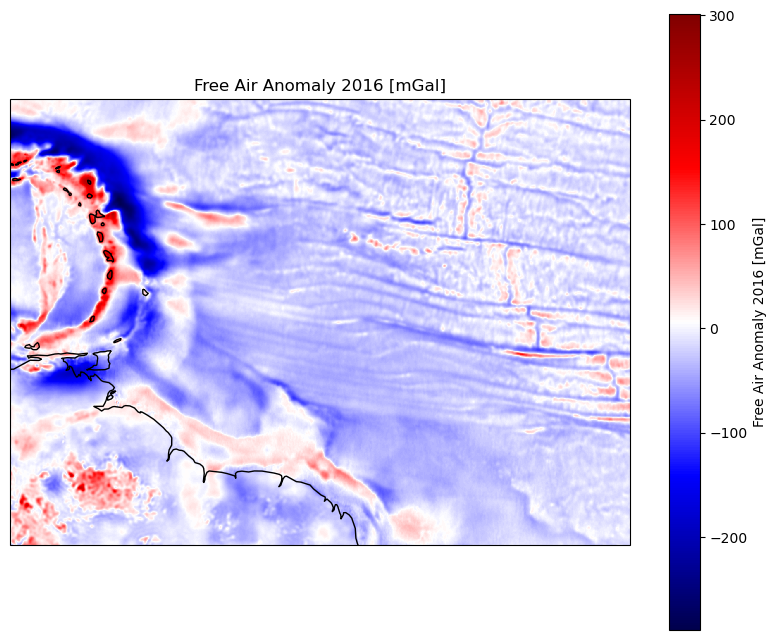

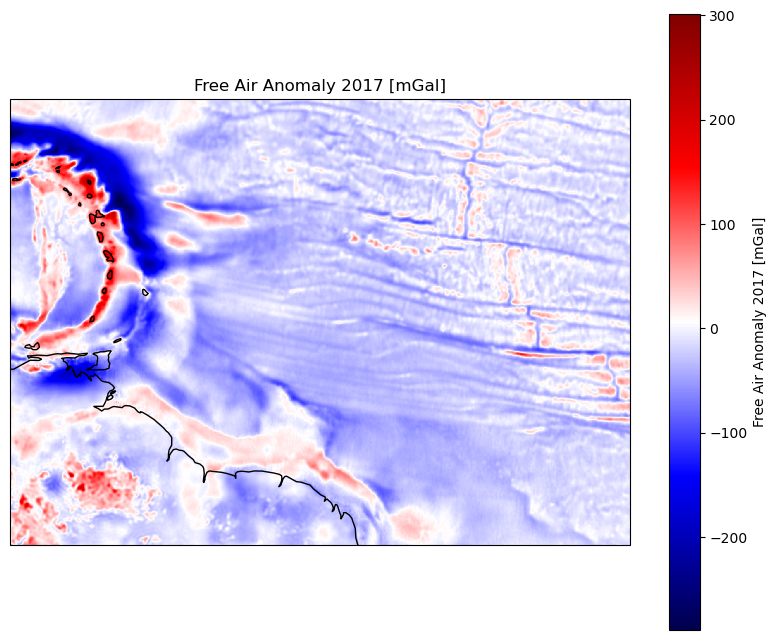

In [4]:
def plot_grd(datafile, title, vmin=None, vmax=None, norm=None, cmap="seismic"):
    ds = xr.open_dataset(datafile)
    
    lon = ds['lon'].values
    lat = ds['lat'].values
    
    data_var_name = [v for v in ds.data_vars][0]
    data = ds[data_var_name].values
    
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))
    pcm = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm, shading='auto')
    ax.coastlines()
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(pcm, ax=ax, label=title)
    plt.show()

# File paths
grav_24 = "E:/Ania/Grav/Python_Scripts/satellite_data_for_each_year/grav_24.grd"
curv_24 = "E:/Ania/Grav/Python_Scripts/satellite_data_for_each_year/curv_24.grd"
grav_25 = "E:/Ania/Grav/Python_Scripts/satellite_data_for_each_year/grav_25.grd"
curv_25 = "E:/Ania/Grav/Python_Scripts/satellite_data_for_each_year/curv_25.grd"

norm_curv = SymLogNorm(
    linthresh=10,
    linscale=1.0,
    vmin=-200,
    vmax=470,
    base=10
)

# Plotting 2016 (24)
plot_grd(grav_24, "Free Air Anomaly 2016 [mGal]", cmap="seismic")
# plot_grd(curv_24, "Vertical Gravity Gradient 2016 [mGal/km]", norm=norm_curv, cmap="seismic")

# Plotting 2017 (25)
plot_grd(grav_25, "Free Air Anomaly 2017 [mGal]", cmap="seismic")
# plot_grd(curv_25, "Vertical Gravity Gradient 2017 [mGal/km]", norm=norm_curv, cmap="seismic")

In [5]:
import xarray as xr

def read_grd_file_xr(filename):
    ds = xr.open_dataset(filename)
    print(ds)
    lon = ds['lon'].values
    lat = ds['lat'].values
    data_var = list(ds.data_vars)[0]  # first variable
    data = ds[data_var].values
    return lon, lat, data

# Usage
lon, lat, sat_grav = read_grd_file_xr("E:/Ania/Grav/Python_Scripts/satellite_data_for_each_year/grav_25.grd")


<xarray.Dataset> Size: 7MB
Dimensions:  (lon: 1500, lat: 1080)
Coordinates:
  * lon      (lon) float64 12kB -64.99 -64.97 -64.96 ... -40.04 -40.02 -40.01
  * lat      (lat) float64 9kB 3.008 3.025 3.042 3.058 ... 20.96 20.98 20.99
Data variables:
    z        (lat, lon) float32 6MB ...
Attributes:
    Conventions:  CF-1.7
    title:        
    history:      gmt grdsample -R-65/-40/3/21 -I1m @GMTAPI@-S-I-G-G-G-N-0000...
    description:  
    GMT_version:  6.5.0 [64-bit]
    node_offset:  1


In [9]:
garanti_paths = [
    "E:/Ania/Grav/Python_Scripts/Garanti_GravMag/gravi-bord/Gravi/garanti1.xyz",
    "E:/Ania/Grav/Python_Scripts/Garanti_GravMag/gravi-bord/Gravi/garanti2.xyz",
    "E:/Ania/Grav/Python_Scripts/Garanti_GravMag/gravi-bord/Gravi/garanti3.xyz"
]

def load_gravity_file(file_path, skiprows=22):
    df = pd.read_csv(
        file_path,
        sep=r"\s+",
        skiprows=skiprows,
        names=["date", "time", "lat", "lon", "grav", "FAA"],
        engine="python"
    )
    df = df[df["FAA"] != -2147483648.00]
    return df

df_garanti = pd.concat([load_gravity_file(p) for p in garanti_paths], ignore_index=True)
df_garanti["mission"] = "Garanti"

antithesis_path = "E:/Ania/Grav/Python_Scripts/Antithesis1/Grav/antithesis_grav_vrai.dat"

def load_antithesis(file_path, skiprows=17):
    df = pd.read_csv(
        file_path,
        sep=r"\s+",
        skiprows=skiprows,
        names=["date", "time", "lat", "lon", "FAA"],
        engine="python"
    )
    df = df[df["FAA"] != -2147483648.00]
    df["mission"] = "Antithesis"
    return df

df_antithesis = load_antithesis(antithesis_path)





In [12]:
ds = xr.open_dataset("E:/Ania/Grav/Python_Scripts/satellite_data_for_each_year/grav_25.grd")

lon = ds["lon"].values         
lat = ds["lat"].values         
sat_grav = ds["z"].values      

# Create interpolator
# Note: RegularGridInterpolator expects coordinate arrays in increasing order
# and data array shape to match coordinate arrays order (lat, lon here)

interpolator = RegularGridInterpolator(
    (lat, lon),           # coordinate grids (lat, lon)
    sat_grav,             # data values
    bounds_error=False,
    fill_value=np.nan
)

# Suppose df_garanti contains shipborne data with columns ['lat', 'lon']
points = df_garanti[["lat", "lon"]].values

# Interpolate satellite gravity at shipborne locations
df_garanti["satellite_gravity"] = interpolator(points)

# Save result if needed
df_garanti.to_csv("garanti_with_satellite_gravity.csv", index=False)


In [13]:
df_garanti['difference'] = df_garanti['FAA'] - df_garanti['satellite_gravity']

In [14]:
print(df_garanti['difference'].describe())

count    3.788556e+06
mean     1.705007e+00
std      4.687861e+00
min     -5.839738e+01
25%     -7.038461e-01
50%      1.356571e+00
75%      3.564560e+00
max      4.243693e+01
Name: difference, dtype: float64


In [15]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    df_garanti,
    geometry=gpd.points_from_xy(df_garanti.lon, df_garanti.lat),
    crs="EPSG:4326"
)

# Example: Reproject to UTM zone 20N (adjust if needed)
gdf_utm = gdf.to_crs("EPSG:32620")

gdf_utm["x"] = gdf_utm.geometry.x
gdf_utm["y"] = gdf_utm.geometry.y

df_garanti_projected = gdf_utm.drop(columns="geometry")

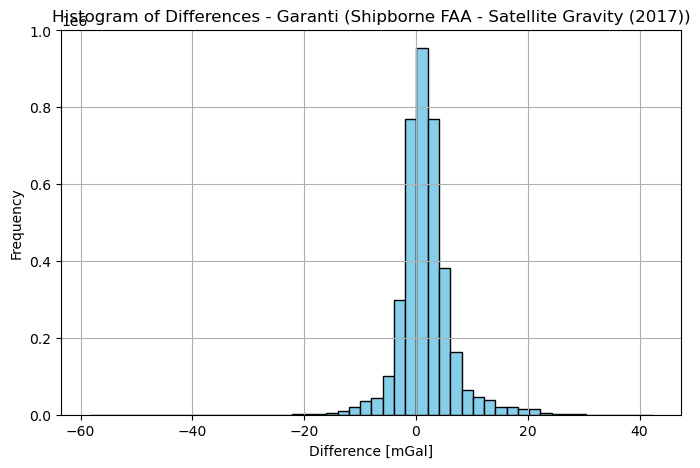

In [16]:

plt.figure(figsize=(8, 5))
plt.hist(df_garanti['difference'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Differences - Garanti (Shipborne FAA - Satellite Gravity (2017))')
plt.xlabel('Difference [mGal]')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

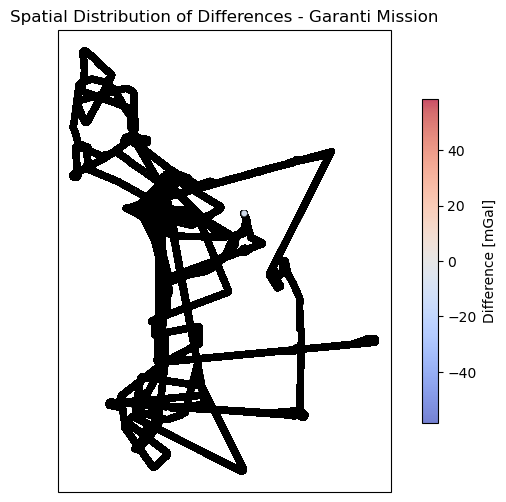

In [17]:

def plot_difference_map(df, title):
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))

    sc = ax.scatter(
        df['lon'], df['lat'],
        c=df['difference'],
        cmap='coolwarm',
        s=20,
        edgecolor='k',
        linewidth=0.3,
        alpha=0.7,
        vmin=-np.max(np.abs(df['difference'])),
        vmax=np.max(np.abs(df['difference']))
    )

    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7, pad=0.05)
    cbar.set_label('Difference [mGal]')
    plt.show()


plot_difference_map(df_garanti, 'Spatial Distribution of Differences - Garanti Mission')
# plot_difference_map(df_antithesis, 'Spatial Distribution of Differences - Antithesis Mission')

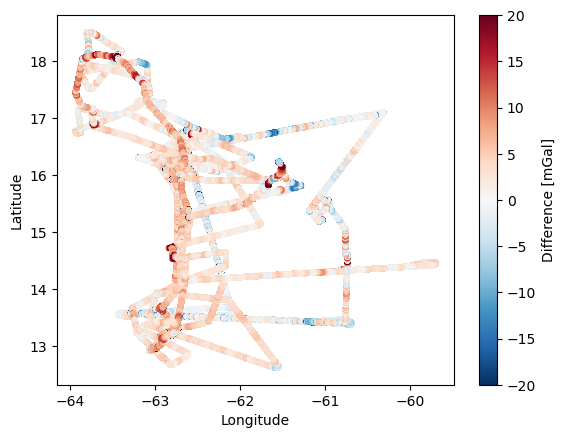

In [19]:
plt.scatter(df_garanti['lon'], df_garanti['lat'], c=df_garanti['difference'],
            cmap='RdBu_r', s=10, vmin=-20, vmax=20)
plt.colorbar(label='Difference [mGal]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [20]:
print("Garanti: \n")
print(df_garanti['difference'].describe())

Garanti: 

count    3.788556e+06
mean     1.705007e+00
std      4.687861e+00
min     -5.839738e+01
25%     -7.038461e-01
50%      1.356571e+00
75%      3.564560e+00
max      4.243693e+01
Name: difference, dtype: float64


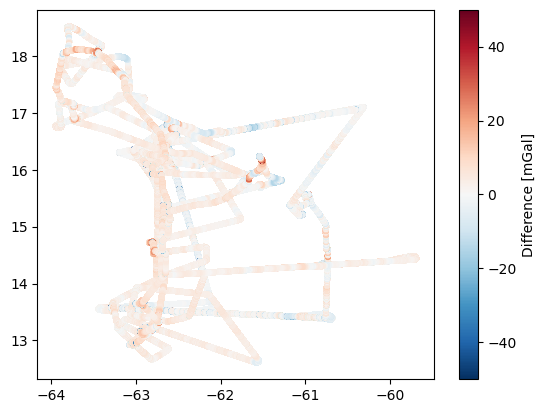

In [21]:
vmin, vmax = -50, 50  # set to a sensible range based on your data stats
sc = plt.scatter(df_garanti['lon'], df_garanti['lat'], c=df_garanti['difference'],
                cmap='RdBu_r', s=10, vmin=vmin, vmax=vmax)
plt.colorbar(sc, label='Difference [mGal]')

In [22]:
print(df_garanti['difference'].isna().sum())  # should be 0 or low
print(df_garanti['difference'].min(), df_garanti['difference'].max())

0
-58.39737875873691 42.436930693809515


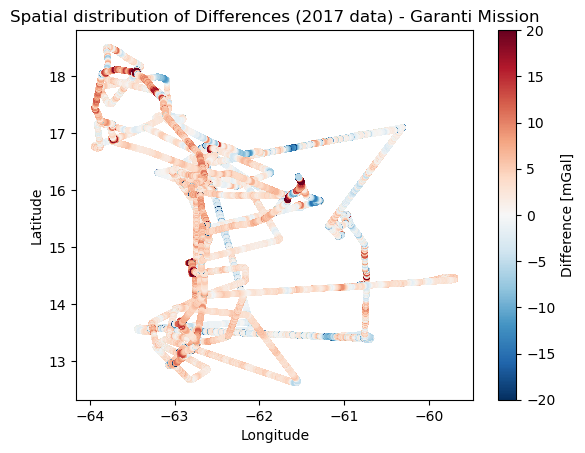

In [23]:
plt.scatter(df_garanti['lon'], df_garanti['lat'], c=df_garanti['difference'],
            cmap='RdBu_r', s=10, vmin=-20, vmax=20)
plt.colorbar(label='Difference [mGal]')
plt.title("Spatial distribution of Differences (2017 data) - Garanti Mission")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()